<center> <img src = https://upload.wikimedia.org/wikipedia/commons/e/e3/Booking.com_logo2.png alt="drawing" style="width:400px;">

## Постановка задачи

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

---

## Загрузка данных

In [492]:
# импортируем необходимые модули
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')
#nltk.download('movie_reviews')
#nltk.download('punkt')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [493]:
RANDOM_SEED = 42

In [494]:
# загружаем датасет
hotels = pd.read_csv('hotels.csv')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [495]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [496]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


---

## Очистка данных

In [497]:
# удаляем полные дупликаты
hotels = hotels.drop_duplicates(ignore_index=True)
print(f'Результирующее число записей: {hotels.shape[0]}')

Результирующее число записей: 386496


Пока что заполним пропущенные широту и долготу нулями, затем если обнаружим заисимость оценки от этих признаков, заполним их по адресу

In [498]:
# заменяем пропуски на нули
values = {'lat': 0, 'lng': 0}
hotels = hotels.fillna(values)

При осмотре общих статистик, у некоторых признаков можно заметить большую разницу между максимальным значением и 75 процентилем, что является признаком наличия выбросов. Посмотрим на распределения этих признаков.

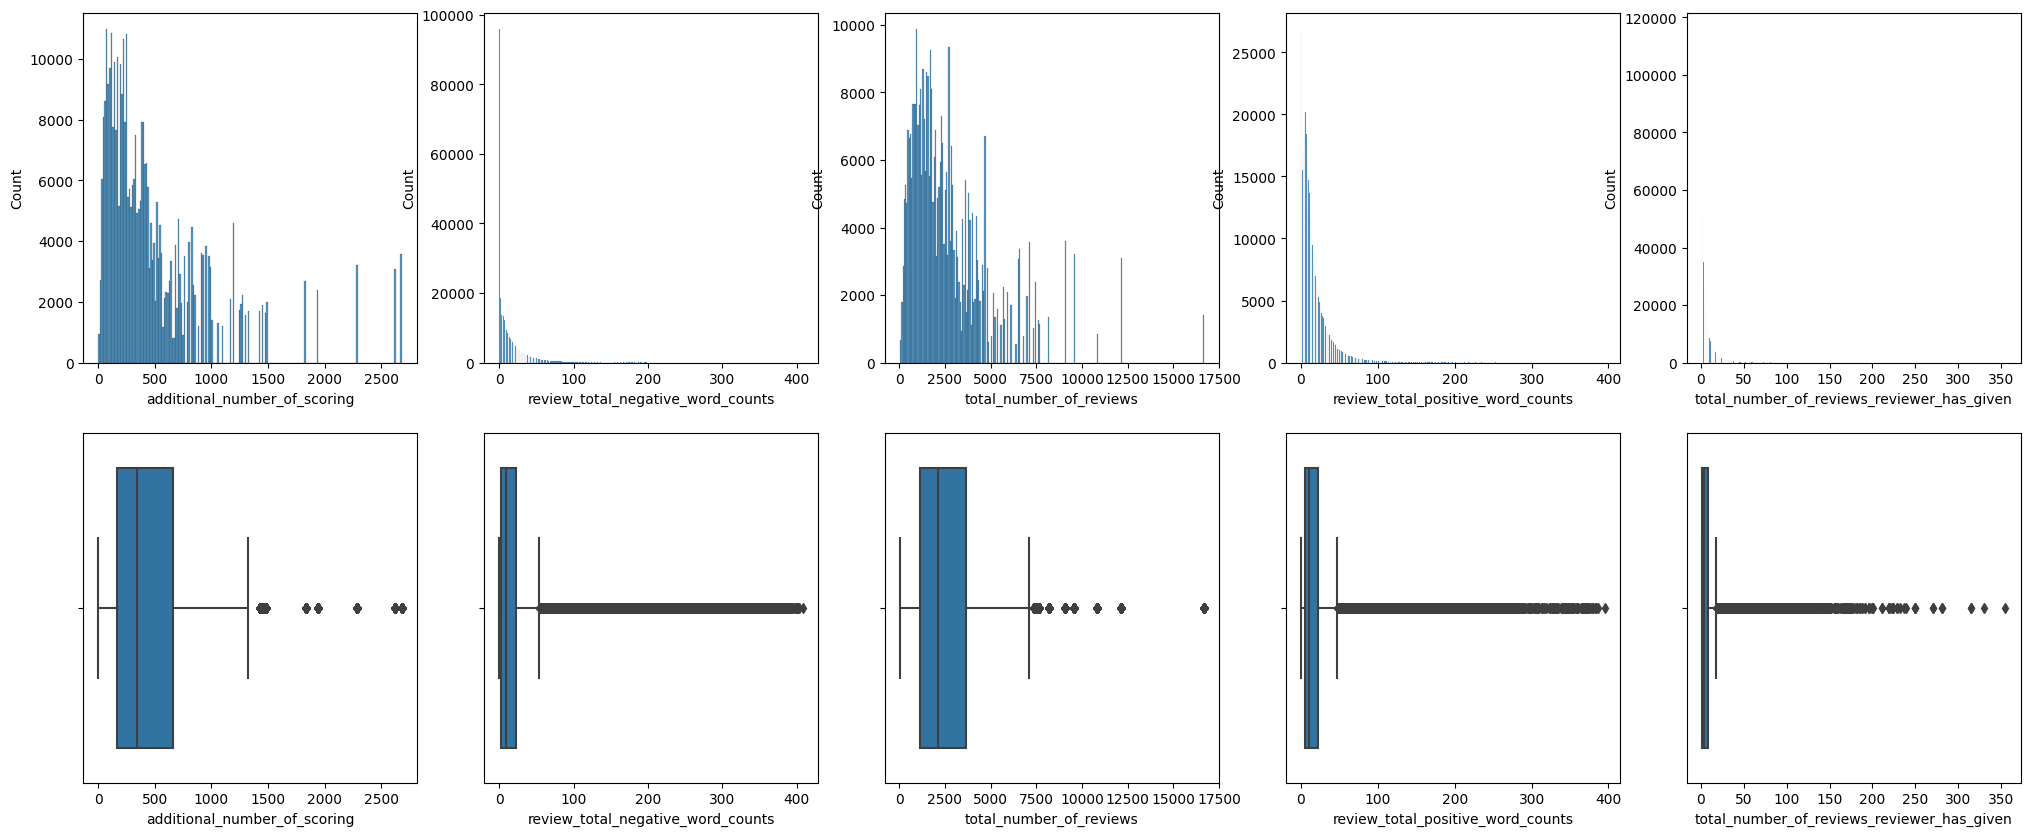

In [499]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize = (25, 10))

outliers_fig = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
n = 0
for i in outliers_fig:
    histplot = sns.histplot(data=hotels, x=i, ax=axes[0][n]);
    boxplot = sns.boxplot(data=hotels, x=i, ax=axes[1][n]);
    n += 1

Из распределений видно что имеются выбросы, но данные значения признаков вполне имеют право на существование, т.к. например для особенно популярного отеля вполне может быть выставленно большое количество оценок или отзывов. 

На данном этапе удалять выбросы не будем.

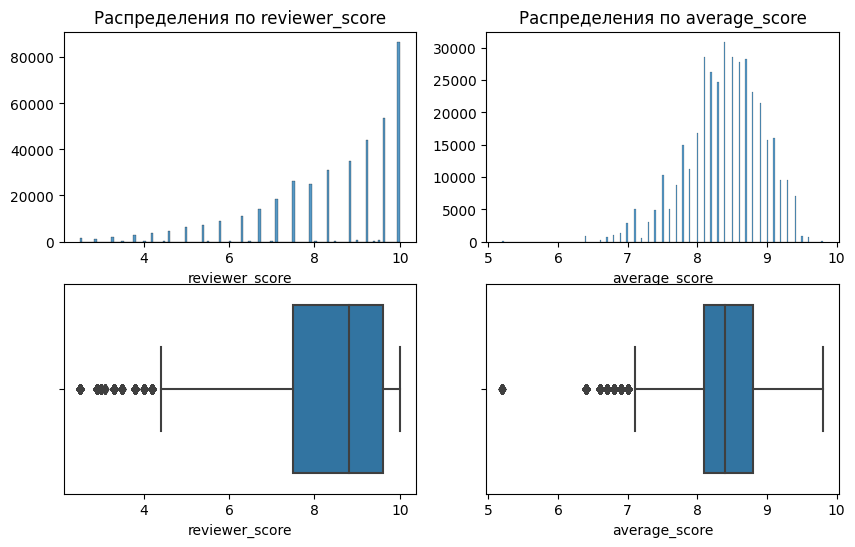

In [500]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
histplot = sns.histplot(data=hotels, x='reviewer_score', ax=axes[0][0])
histplot.set_title('Распределения по reviewer_score')
histplot.set_ylabel('')
boxplot = sns.boxplot(data=hotels, x='reviewer_score', ax=axes[1][0])
histplot = sns.histplot(data=hotels, x='average_score', ax=axes[0][1])
histplot.set_title('Распределения по average_score')
histplot.set_ylabel('')
boxplot = sns.boxplot(data=hotels, x='average_score', ax=axes[1][1])

In [501]:
hotels = hotels.reset_index(drop=True)

---

## Разведывательный анализ данных

### Проектирование признаков

In [502]:
train_data = hotels.copy()
train_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


Набросаем примерный план обработки признаков:
* Из признака hotel_address возьмём страну и город
* Из признака review_date: год, месяц и квартал
* hotel_name скорее всего ничем не поможет
* reviewer_nationality, есть две идеи:
    1. из внешних источников взять какой-нибудь индекс качества жизни (возможно рецензенты из стран с низким качеством жизни ставят отелям более высокие оценки)
    2. возможно рецензенты, национальность которых совпадает с страной отеля, ставят оценки выше либо ниже
* negative_review и positive_review, можно попробовать разделить на степени недовольства или удовлетворённости, по вхождению в отзыв таких слов как: восхитительный, великолепный или отвратительный, мерзкий
* Из признака tags можно будет выделить: тип поездки, количество комнат в номере, количество человек и т.д.

In [503]:
#########################################################################
train_data['0_review_word_counts_ratio'] = (train_data['review_total_positive_word_counts'] + 1) / (train_data['review_total_negative_word_counts'] + 1)
train_data['0_a_n_o_s__t_n_o_r'] = (train_data['additional_number_of_scoring'] + 1) / (train_data['total_number_of_reviews'] + 1)
#train_data['0_avg_avg_score'] = train_data['average_score'] / train_data['average_score'].mean()


#### <CENTER>Признак hotel_address</CENTER>

In [504]:
n = 0
for i in train_data['hotel_address']:
    print(i)
    n += 1
    if n > 5:
        break

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy


Из данного признака выделим страну и город расположения отеля

In [505]:
def hotel_address_func(data):
    """Функция преобразования признака hotel_address

    Args:
        data (DataFrame): Изначальный датасет

    Returns:
        DataFrame: преобразованный датасет
    """
    data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if (x.split()[-1] != 'Kingdom') else (x.split()[-2] + ' ' + x.split()[-1])) # создаём признак страна отеля
    data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2] if (x.split()[-1] != 'Kingdom') else x.split()[-5])                            # создаём признак город отеля
    
    return data


In [506]:
train_data = hotel_address_func(train_data)

In [507]:
print('Страна расположения отелей\n', train_data['country'].value_counts(), '\n')
print('Город расположения отелей\n', train_data['city'].value_counts())

Страна расположения отелей
 United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: country, dtype: int64 

Город расположения отелей
 London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: city, dtype: int64


Сразу подметим что два новых признака полностью совпадают (для каждой страны по одному городу), значит в дальнейшем один из них, удалим. Так как все страны из Европы, то географичиские координаты вероятнее всего нам не понадобятся.

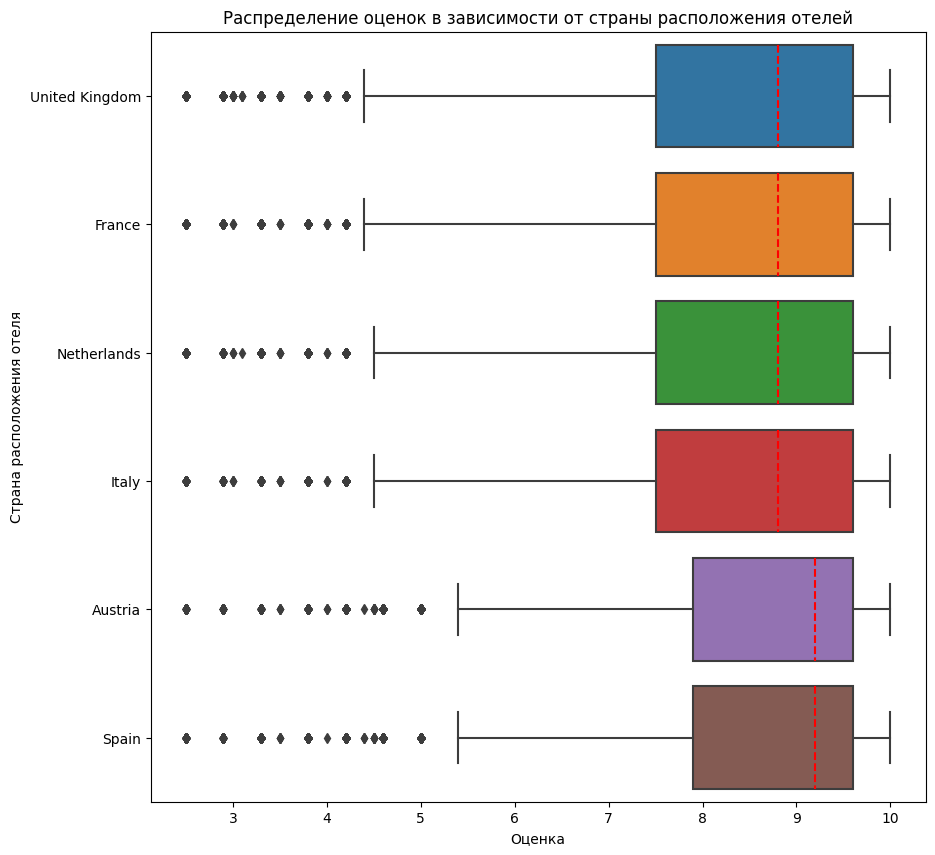

In [508]:
ax = sns.boxplot(train_data, x='reviewer_score', y='country', orient='h', medianprops={'color':'red', 'linestyle':'--'})
ax.set(xlabel='Оценка', ylabel='Страна расположения отеля')
plt.title('Распределение оценок в зависимости от страны расположения отелей')
plt.show()

Судя по распределениям, статистически значимая зависимость оценок от страны, отсутствует.

#### <CENTER>Признак review_date</CENTER>

Из даты нам пригодятся: год, месяц и квартал

In [509]:
def review_date_func(data):
    """Функция преобразования признака review_date

    Args:
        data (DataFrame): Изначальный датасет

    Returns:
        DataFrame: преобразованный датасет
    """
    data['review_date'] = pd.to_datetime(data['review_date'])
    
    data['review_year'] = data['review_date'].dt.year           # год
    data['review_month'] = data['review_date'].dt.month         # месяц
    data['review_quarter'] = data['review_date'].dt.quarter     # квартал
    
    return data

In [510]:
train_data = review_date_func(train_data)

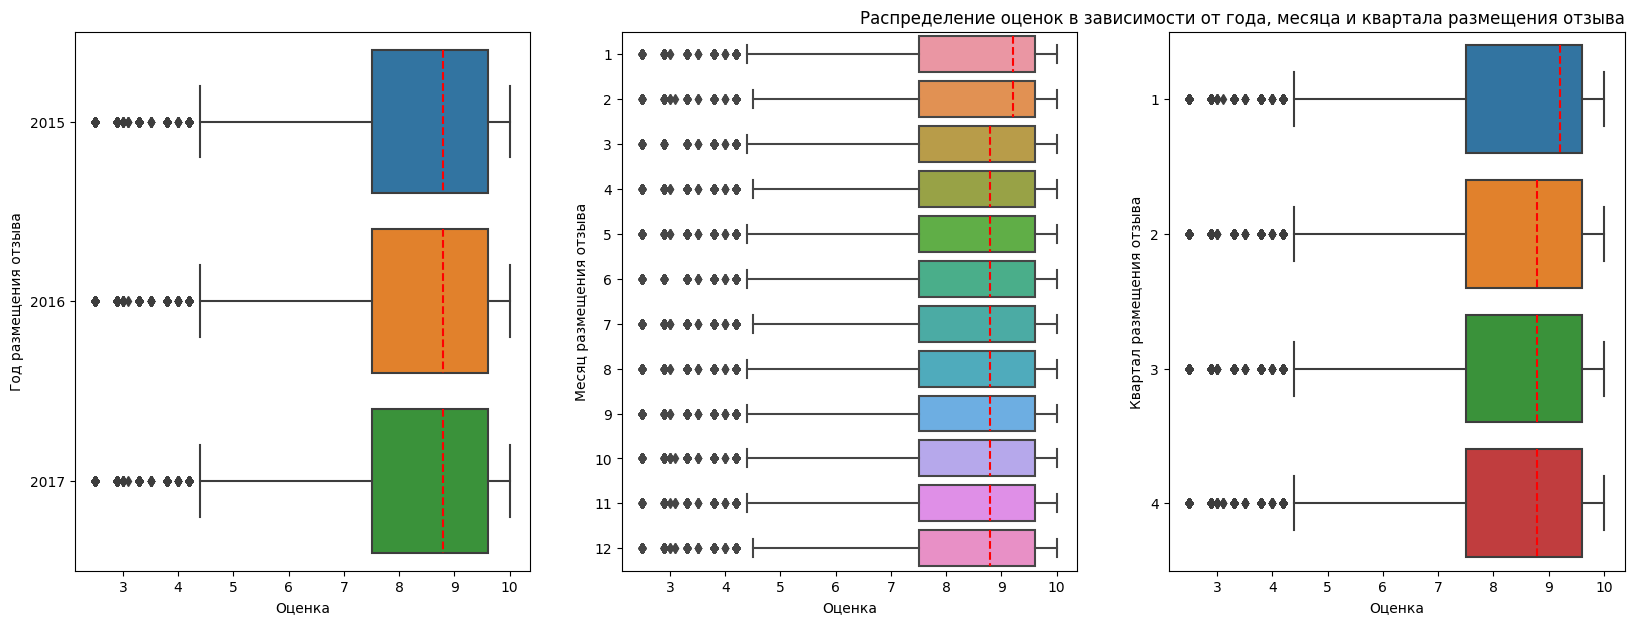

In [511]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
sns.boxplot(train_data, x='reviewer_score', y='review_year', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[0])
axes[0].set(xlabel='Оценка', ylabel='Год размещения отзыва')
sns.boxplot(train_data, x='reviewer_score', y='review_month', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[1])
axes[1].set(xlabel='Оценка', ylabel='Месяц размещения отзыва')
sns.boxplot(train_data, x='reviewer_score', y='review_quarter', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[2])
axes[2].set(xlabel='Оценка', ylabel='Квартал размещения отзыва')

plt.title('Распределение оценок в зависимости от года, месяца и квартала размещения отзыва', loc='right')
plt.show()

Оценка независит от даты размещения отзыва

#### <CENTER>Признак hotel_name</CENTER>

In [512]:
train_data['hotel_name'].head(10)

0                           The May Fair Hotel
1              Mercure London Bloomsbury Hotel
2            Legend Saint Germain by Elegancia
3    Mercure Paris 19 Philharmonie La Villette
4                  Golden Tulip Amsterdam West
5              Novotel Milano Linate Aeroporto
6          Holiday Inn London Kensington Forum
7                       Mercure Josefshof Wien
8         The Gore Hotel Starhotels Collezione
9               Hilton London Kensington Hotel
Name: hotel_name, dtype: object

Данный признак не информативен

#### <CENTER>Признак reviewer_nationality</CENTER>

1. Создадим признак совпадения национальности и страны отеля
2. Возьмём из внешних источников уровень качества жизни и среднюю зарплату

In [513]:
def reviewer_nationality_func(data):
    """Функция преобразования признака reviewer_nationality
       Создаём признак совпадения национальности и страны отеля и
       добавляем из внешних источников уровень качества жизни и среднюю зарплату.
    Args:
        data (DataFrame): Изначальный датасет

    Returns:
        DataFrame: преобразованный датасет
    """   
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())                                                      # удаляем лишние пробелы в названиях
    
    # 1. Создаём признак совпадения национальности и страны отеля
    data['country_equal_nation'] = 0
    for i in range(data.shape[0]):
        data.at[i, 'country_equal_nation'] = 1 if (data.at[i, 'reviewer_nationality'] == data.at[i, 'country']) else 0


    # 2. Создаём признак уровень качества жизни в стране рецензента
    # код для получения словаря стран и индекса уровня качества жизни
    url = 'https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2017&displayColumn=0'
    response = requests.get(url)                                                                                                                # делаем get запрос
    page = BeautifulSoup(response.text, 'html.parser')                                                                                          # готовим суп (получаем объект типа BeautifulSoup)

    countries = page.find_all('td', class_="cityOrCountryInIndicesTable")                                                                       # поиск стран по тегам
    indexes = page.find('tbody').find_all('td', style="text-align: right")                                                                      # поиск индексов по тегам

    country_dict = {'nation_country':[country.text for country in countries], 'quality_of_life':[float(indexx.text) for indexx in indexes]}     # собираем словарь
    country_dict['nation_country'].extend(['Kuwait', 'Malta', 'Bahrain', 'Oman', 'Luxembourg', 'Iceland', 'Jersey'])                            # дополняем словарь недостающими значениями стран
    country_dict['quality_of_life'].extend([146.0, 142.0, 146.0, 146.0, 185.0, 165.0, 170.0])                                                   # и их индексами
    # добавляем новый признак в наш датасет
    quality_life = pd.DataFrame(data=country_dict)
    quality_life['nation_country'] = quality_life['nation_country'].apply(lambda x: x if x != 'United States' else 'United States of America')  # названия США не сходятся, меняем
    
    data = data.join(quality_life.set_index('nation_country'), on='reviewer_nationality', how='left')                                           # джойним слева
    data['quality_of_life'] = data['quality_of_life'].fillna(95.0)                                                                              # в спарсеных данных нехватало индексов по странам африки и ещё некоторых, в среднем их индекс равен 95


    # 3. Создаём признак средне-месячная зарплата(долл.) в стране рецензента
    # код для получения словаря стран и средне-месячной зарплаты
    url = 'https://www.numbeo.com/cost-of-living/country_price_rankings?displayCurrency=USD&itemId=105'
    response = requests.get(url)                                                                                                                # делаем get запрос
    page = BeautifulSoup(response.text, 'html.parser')                                                                                          # готовим суп (получаем объект типа BeautifulSoup)

    countries = page.find_all('td', style="vertical-align: top")                                                                                # поиск стран по тегам
    avg_salary = page.find_all('td', style="vertical-align: top; text-align: right")                                                            # поиск зарплаты по тегам

    salary_dict = {'nation_country':[country.text.replace('\n', '') for country in countries], 'avg_month_salary':[float(sal.text.replace('\n', '').replace('\xa0$', '').replace(',', '')) for sal in avg_salary]}# собираем словарь
    salary_dict['nation_country'].extend(['Bahrain', 'Jersey'])                                                                                 # дополняем словарь недостающими значениями стран
    salary_dict['avg_month_salary'].extend([2000.0, 2300.0])                                                                                    # и зарплатами
    # добавляем новый признак в наш датасет
    salary_df = pd.DataFrame(data=salary_dict)
    salary_df['nation_country'] = salary_df['nation_country'].apply(lambda x: x if x != 'United States' else 'United States of America')        # названия США опять не сходятся, меняем
    salary_df['nation_country'] = salary_df['nation_country'].apply(lambda x: x if x != 'Hong Kong (China)' else 'Hong Kong')                   # и Гонк Конг
    
    data = data.join(salary_df.set_index('nation_country'), on='reviewer_nationality', how='left')                                              # джойним слева
    data['avg_month_salary'] = data['avg_month_salary'].fillna(330.0)                                                                           # и снова дополняем недостающие данные
    
    return data

In [514]:
train_data = reviewer_nationality_func(train_data)

#### <CENTER>Признак negative_review и positive_review</CENTER>

In [515]:
def review_word_count(data):   
    data['negative_review'] = data['negative_review'].apply(lambda s: s.lower())
    data['positive_review'] = data['positive_review'].apply(lambda s: s.lower())
    data['neg_review_split'] = data['negative_review'].apply(lambda s: s.split())
    data['pos_review_split'] = data['positive_review'].apply(lambda s: s.split())

    def not_alpha(words_list):
        return [word for word in words_list if word.isalpha()]

    data['neg_review_split'] = data['neg_review_split'].apply(not_alpha)
    data['pos_review_split'] = data['pos_review_split'].apply(not_alpha)
    
    data['negative_review'] = data['neg_review_split'].apply(lambda s: ' '.join(s))
    data['positive_review'] = data['pos_review_split'].apply(lambda s: ' '.join(s))
    
    data['review_total_negative_word_counts'] = data['neg_review_split'].apply(len)
    data['review_total_positive_word_counts'] = data['pos_review_split'].apply(len)
    
    data = train_data.drop(['neg_review_split', 'pos_review_split'], axis=1)
    
    return data

train_data = review_word_count(train_data)

In [516]:
print('Positive\n')
n = 0
for i in train_data['positive_review']:
    print(i)
    n += 1
    if n > 10:
        break
print('\nNegative\n')
n = 0
for i in train_data['negative_review']:
    print(i)
    n += 1
    if n > 10:
        break

Positive

staff were amazing
location
no positive
friendly staff quiet comfortable room spotlessly clean excellent location
the staff was very friendly and helpful breakfasts were just extraordinary room was clean quiet and very spacious
very nice hotel price is excellent when compared to quality very quiet good food
very central location minutes walk from gloucester rd tube station and minutes walk from the museums lots of restaurants and bars on the doorstep
the location is good for transport links especially if you are a tram lover the number stops two minutes away easy walk to the centre past the rathaus and as a bonus there is an excellent non smoking cafe opposite the tram stop we had a superior privilege room which was a strange shape with sloping roof even though we weren t on the top floor very bling gold decor i liked the klimpt bathroom door but comfortable clean and with a good walk in shower the street above the hotel has a supermarket some nice niche shops and good restau

Я не очень хорошо разбираюсь в английском языке, поискал в интернете различные междометия и фразы, посмотрим что из этого получится.

In [517]:
def pos_neg_rev_func(data):
    """Функция преобразования признаков positive_review и negative_review
       Создаём признаки количества вхождений высокоэмоциональных слов.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    # списки слов которые я нашёл, из некоторых убрал окончание чтобы учесть разные склонения
    positive_phrases = ['Wow', 'Brilliant', 'Awesome', 'Amazing', 'Magnificent', 'Unbelievable', 'Wonderful', 'Perfect', 'Divine', 'Ineffable', 'Inexpressible', 'Magic', 'Fantastic', 'cool', 'Charming', 'Adorab', 'Inspiring', 'happy', 'good', 'nice', 'Cute']
    negative_phrases = ['jeez', 'horr', 'abominable', 'contempt', 'disgust', 'terrible', 'nasty', 'bad', 'aggress', 'anger', 'annoy', 'enrage', 'frustrate', 'hostil', 'huff', 'Shit', 'Bullshit', 'Boo', 'hate', 'disappoint', 'Poof', 'Yuck', 'Damn', 'poor']
    # приведём все строки к нижнему регистру
    positive_phrases = [x.lower() for x in positive_phrases]
    negative_phrases = [x.lower() for x in negative_phrases]
    
    neg_quality_room = ['nois', 'dirt', 'mud', 'litter', 'dust', 'clamor', 'roar']
    pos_quality_room = ['pure', 'clean', 'quiet', 'calm']

    # далее подсчитаем частоту вхождения данных слов в отзыв и создадим два новых признака: positiv_emo_words, negativ_emo_words
    def positive_word_cnt(review, flag=0):                  # функция подсчета количества позитивных слов
        rev_words = review.split()
        count_pos_phra = 0
        count_pos_qual = 0 
        for word in rev_words:
            for pos_phrase in positive_phrases:
                if word.lower().find(pos_phrase)+1:
                    count_pos_phra += 1
            for pos in pos_quality_room:
                if word.lower().find(pos)+1:
                    count_pos_qual += 1
        if flag == 0:
            return count_pos_phra
        if flag == 1:
            return count_pos_qual

    def negative_word_cnt(review, flag=0):                  # функция подсчета количества негативных слов
        rev_words = review.split()
        count_neg_phra = 0
        count_neg_qual = 0
        for word in rev_words:
            for neg_phrase in negative_phrases:
                if word.lower().find(neg_phrase)+1:
                    count_neg_phra += 1
            for neg in neg_quality_room:
                if word.lower().find(neg)+1:
                    count_neg_qual += 1
        if flag == 0:
            return count_neg_phra
        if flag == 1:
            return count_neg_qual

    # создаём новые признаки
    data['positiv_emo_words'] = data['positive_review'].apply(positive_word_cnt)
    data['negativ_emo_words'] = data['negative_review'].apply(negative_word_cnt)
    data['positiv_quality_room'] = data['positive_review'].apply(positive_word_cnt, flag=1)
    data['negativ_quality_room'] = data['negative_review'].apply(negative_word_cnt, flag=1)
    
    return data

In [518]:
train_data = pos_neg_rev_func(train_data)

In [519]:
train_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,review_year,review_month,review_quarter,country_equal_nation,quality_of_life,avg_month_salary,positiv_emo_words,negativ_emo_words,positiv_quality_room,negativ_quality_room
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,2016,2,1,1,172.9,2928.85,1,0,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,location,...,2017,1,1,1,172.9,2928.85,0,1,0,0


In [520]:
print(train_data['positiv_emo_words'].value_counts())
print(train_data['negativ_emo_words'].value_counts())

0     233552
1     109641
2      32362
3       8145
4       2005
5        560
6        157
7         50
8         15
9          7
10         2
Name: positiv_emo_words, dtype: int64
0     345254
1      32343
2       6275
3       1681
4        574
5        193
6         81
7         43
8         27
9         16
10         6
11         3
Name: negativ_emo_words, dtype: int64


Как видим, на первый взгляд, работает не плохо, но возможно я неучёл какието слова из-за незнания языка.

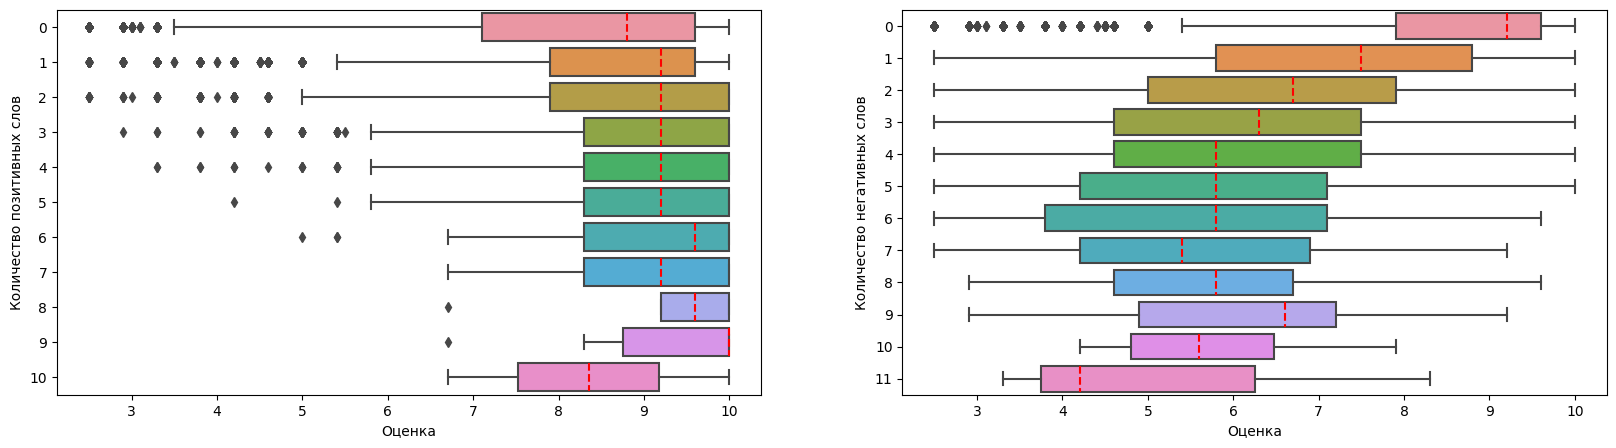

In [521]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot(train_data, x='reviewer_score', y='positiv_emo_words', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[0])
axes[0].set(xlabel='Оценка', ylabel='Количество позитивных слов')
sns.boxplot(train_data, x='reviewer_score', y='negativ_emo_words', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[1])
axes[1].set(xlabel='Оценка', ylabel='Количество негативных слов');

Из распределений заметна зависимость оценки от количества негативных слов

In [522]:
#####################################################################
train_data['pos_neg_dev_emo'] = (train_data['positiv_emo_words']+1) / (train_data['negativ_emo_words']+1)
train_data['neg_emo_dev_r_t_n_w_c'] = (train_data['negativ_emo_words']+1) / (train_data['review_total_negative_word_counts']+1)
train_data['pos_emo_dev_r_t_p_w_c'] = (train_data['positiv_emo_words']+1) / (train_data['review_total_positive_word_counts']+1)
train_data['0_pos_neg'] = (train_data['pos_emo_dev_r_t_p_w_c']+1) / (train_data['neg_emo_dev_r_t_n_w_c']+1)
train_data = train_data.drop(['pos_emo_dev_r_t_p_w_c', 'neg_emo_dev_r_t_n_w_c'], axis=1)
train_data['pos_neg_ratio_quality'] = (train_data['positiv_quality_room']+1) / (train_data['negativ_quality_room']+1)


In [523]:
def polarity(review):
    sent = TextBlob(review)
    return sent.sentiment[0]
def subjectivity(review):
    sent = TextBlob(review)
    return sent.sentiment[1]
train_data['pos_polarity'] = train_data['positive_review'].apply(polarity)
train_data['pos_subjectivity'] = train_data['positive_review'].apply(subjectivity)
train_data['neg_polarity'] = train_data['negative_review'].apply(polarity)
train_data['neg_subjectivity'] = train_data['negative_review'].apply(subjectivity)
train_data['pos_neg_polar_comp'] = train_data['pos_polarity'] + train_data['neg_polarity']
train_data['pos_neg_subj_comp'] = train_data['pos_subjectivity'] + train_data['neg_subjectivity']

In [524]:
def nltk_analyz(data):
    sia_neg = SentimentIntensityAnalyzer()
    sia_pos = SentimentIntensityAnalyzer()

    data['neg_scores_in'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
    data['pos_scores_in'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

    # формируем новые признаки:
    data['n_review_sentiments_neg_in'] = data['neg_scores_in'].apply(lambda x: x['neg'])
    data['n_review_sentiments_neu_in'] = data['neg_scores_in'].apply(lambda x: x['neu'])
    data['n_review_sentiments_pos_in'] = data['neg_scores_in'].apply(lambda x: x['pos'])
    data['n_review_sentiments_compound_in'] = data['neg_scores_in'].apply(lambda x: x['compound'])

    data['p_review_sentiments_neg_in'] = data['pos_scores_in'].apply(lambda x: x['neg'])
    data['p_review_sentiments_neu_in'] = data['pos_scores_in'].apply(lambda x: x['neu'])
    data['p_review_sentiments_pos_in'] = data['pos_scores_in'].apply(lambda x: x['pos'])
    data['p_review_sentiments_compound_in'] = data['pos_scores_in'].apply(lambda x: x['compound'])
    
    data = data.drop(['neg_scores_in', 'pos_scores_in'], axis=1)
    
    return data

train_data = nltk_analyz(train_data)

#### <CENTER>Признак tags</CENTER>

Переходим к самому объёмному признаку по содержащейся в нём информации.

Для начала взглянем на все уникальные теги и количество записей где они используются.

In [525]:
all_tags_dict = {}

for tags in train_data['tags']:
    tags = tags.replace("[' ", '')
    tags = tags.replace(" ']", '')
    list_tags = tags.split(" ', ' ")
    for tag in list_tags:
        if tag not in all_tags_dict.keys():
            all_tags_dict[tag] = 1
        else:
            all_tags_dict[tag] += 1
sorted_tags = dict(sorted(all_tags_dict.items(), key=lambda item: item[1], reverse=True))
cnt = 0
for key in sorted_tags:
    if cnt < 20:
        print(key+':',sorted_tags[key])
        cnt += 1
    else:
        break
    

Leisure trip: 313353
Submitted from a mobile device: 230608
Couple: 189046
Stayed 1 night: 145296
Stayed 2 nights: 100176
Solo traveler: 81166
Stayed 3 nights: 71940
Business trip: 61934
Group: 49057
Family with young children: 45810
Stayed 4 nights: 35708
Double Room: 26386
Standard Double Room: 24150
Superior Double Room: 23518
Family with older children: 19787
Deluxe Double Room: 18612
Double or Twin Room: 16824
Stayed 5 nights: 15592
Standard Double or Twin Room: 13058
Classic Double Room: 12604


Уникальных тегов огромное количество, изучив их структуру, можно выделить такие признаки: 

количество мест номера(single, double = twin, triple, quadruple), количество ночей, класс номера(Standard=Classic(c), Superior(s), Executive(e), Deluxe(d), Luxury(l), Business(b), Family(f), Premium(p)), тип номера(Suite, Junior Suite, Apartment, studio, room), королевский размер кровати(Queen, King,) колличество людей(2 Adults 1 Child = 3), семья с детьми(child), с животными, номер с видом, поездка на отдых, бизнес поездка.

In [526]:
def tags_func(data):
    """Функция преобразования признака tags
       Создаём признаки на основе тегов.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    # список признаков которые мы возьмём из тегов
    new_columns = ['leisure_trip', 'business_trip', 'with_view', 'with_pet', 'with_child', 'people_count', 'nights_count', 'number_of_places', 'room_class', 'room_type', 'king_size']
    # цикл по списку признаков
    for colum in new_columns:
        
        def sep_distr_tags(tags_str):
            """Функция выделения необходимого признака
               из строки признака tags   
            Args:
                tags_str (string): строка из признака tags
            Returns:
                Значения для новых признаков
            """
            list_tags = tags_str.replace("[' ", '').replace(" ']", '').split(" ', ' ")
            
            if colum == 'leisure_trip':
                for i in list_tags:
                    if i.lower().find('leisure trip')+1:
                        return 1
            if colum == 'business_trip':
                for i in list_tags:
                    if i.lower().find('business trip')+1:
                        return 1
            if colum == 'with_pet':
                for i in list_tags:
                    if i.lower().find('with a pet')+1:
                        return 1
            if colum == 'with_view':
                for i in list_tags:
                    if i.lower().find('view')+1:
                        return 1
            if colum == 'with_child':
                for i in list_tags:
                    if i.lower().find('child')+1:
                        return 1
            if colum == 'nights_count':
                for i in list_tags:
                    if i.lower().find('stayed ')+1:
                        return int(i.split(' ')[1])
            if colum == 'people_count':
                for i in list_tags:
                    if i.lower().find('solo traveler')+1:
                        return 1
                    elif i.lower().find('couple')+1:
                        return 2
                    elif i.lower().find('adult')+1 and i.lower().find('child')+1:
                        summ = int(i[i.lower().find('adult')-2]) + int(i[i.lower().find('child')-2])
                        return summ
                    elif i.lower().find('adult')+1:
                        return int(i[i.lower().find('adult')-2])
                return 1
            if colum == 'king_size':
                for i in list_tags:
                    if i.lower().find('king')+1 or i.lower().find('queen')+1:
                        return 1
            if colum == 'room_class':
                classes = ['standard', 'classic', 'superior', 'executive', 'deluxe', 'luxury', 'business', 'family', 'premium']
                retur_clas = ''
                for i in list_tags:
                    if i.lower().find('business trip')+1 or i.lower().find('family with')+1:
                        continue
                    for clas in classes:
                        if i.lower().find(clas)+1:
                            if clas == 'standard':  # как я понял номера standard и classic, это в принципе одно и тоже
                                retur_clas += 'c'   # поэтому отнесём их к одному классу
                                continue
                            retur_clas += clas[0]
                if retur_clas == '':
                    return 'o'
                else:
                    sort_clas = sorted(retur_clas)  # обязательно сортируем маркеры классов чтобы избежать повторов,
                    sort_clas = ''.join(sort_clas)  # если классы указаны в разном порядке 
                    return sort_clas
            if colum == 'room_type':
                for i in list_tags:
                    if i.lower().find('junior suite')+1:    # указываем условия поиска типов
                        return 'junior suite'               # в нужном нам порядке чтобы
                    elif i.lower().find('suite')+1:         # выделить наиболее важный тип
                        return 'suite'                      # например из тега "double room family suite"
                    elif i.lower().find('apartment')+1:     # чтобы получить тип "suite"
                        return 'apartment'
                    elif i.lower().find('studio')+1:
                        return 'studio'
                    elif i.lower().find('room')+1:
                        return 'room'
                return 'unknown'
            if colum == 'number_of_places':
                for i in list_tags:
                    if i.lower().find('single')+1:
                        return 1
                    if i.lower().find('double')+1 or i.lower().find('twin')+1:
                        return 2
                    if i.lower().find('triple')+1:
                        return 3
                    if i.lower().find('quadruple')+1:
                        return 4
                return 1
            
            return 0
        # применяем нашу функцию в цикле, для каждого нового признака
        data[colum] = data['tags'].apply(sep_distr_tags)
    # возвращаем обновленный датасет
    return data

train_data = tags_func(train_data)
train_data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,business_trip,with_view,with_pet,with_child,people_count,nights_count,number_of_places,room_class,room_type,king_size
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,0,0,0,0,2,2,1,o,suite,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,location,...,1,0,0,0,2,1,2,c,room,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,no kettle in room,4,406,no positive,...,0,0,0,0,1,3,2,o,room,0


#### <CENTER>Признак days_since_review</CENTER>

In [527]:
train_data['days_since_review'].head(3)

0    531 day
1    203 day
2    289 day
Name: days_since_review, dtype: object

Удалим слово 'day' и изменим тип данных на int

In [528]:
def days_since_func(data):
    data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
    return data

train_data = days_since_func(train_data)
train_data['days_since_review'].head(3)

0    531
1    203
2    289
Name: days_since_review, dtype: int64

In [529]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386496 non-null  object        
 1   additional_number_of_scoring                386496 non-null  int64         
 2   review_date                                 386496 non-null  datetime64[ns]
 3   average_score                               386496 non-null  float64       
 4   hotel_name                                  386496 non-null  object        
 5   reviewer_nationality                        386496 non-null  object        
 6   negative_review                             386496 non-null  object        
 7   review_total_negative_word_counts           386496 non-null  int64         
 8   total_number_of_reviews                     386496 non-null  int64        

### Кодирование признаков

Признаки которые нуждаются в кодировании: country, room_class, room_type, review_year.

Признак country закодируем однократным кодированием.

Признак review_year и room_type, порядковым кодированием, в порядке: room, studio, Apartment, Junior Suite, Suite.

Признак room_class по идее тоже должен быть порядково закодирован, но проблема установить этот порядок, а также имеются сочетания классов, поэтому применим двоичное кодирование.

In [530]:
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

In [531]:
train_data['review_year'].value_counts()

2016    198071
2017    117574
2015     70851
Name: review_year, dtype: int64

In [532]:
def encoding_feature_func(data):
    """Функция кодирования признаков.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    # кодируем признак room_type
    # к сожалению я так и не разобрался как с помощью OrdinalEncoder закодировать в нужном мне порядке, поэтому кодируем вручную.
    roo_typ = [('unknown', 0), ('room', 1), ('studio', 2), ('apartment', 3), ('junior suite', 4), ('suite', 5)]
    roo_typ = pd.DataFrame(roo_typ, columns=['room_type', 'room_type_encode'])   # создаём датасет с типами комнат и порядковыми номерами
    data = data.join(roo_typ.set_index('room_type'), on='room_type', how='left') # и джойним слева
    # кодируем признак country
    encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)             # указываем столбец для кодирования
    type_bin = encoder.fit_transform(data['country'])
    data = pd.concat([data, type_bin], axis=1)
    # кодируем признак room_class
    bin_encoder = ce.BinaryEncoder(cols=['room_class'])                          # указываем столбец для кодирования
    type_bin = bin_encoder.fit_transform(data['room_class'])
    data = pd.concat([data, type_bin], axis=1)
    # кодируем признак review_year
    year_df = [(2015, 1), (2016, 2), (2017, 3), (2018, 4), (2019, 5)]
    year_df = pd.DataFrame(year_df, columns=['review_year', 'review_year_encode'])
    data = data.join(year_df.set_index('review_year'), on='review_year', how='left') # и джойним слева
    
    return data

train_data = encoding_feature_func(train_data)
train_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,country_Netherlands,country_Italy,country_Austria,country_Spain,room_class_0,room_class_1,room_class_2,room_class_3,room_class_4,review_year_encode
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,0,0,0,0,0,0,0,0,1,2
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,location,...,0,0,0,0,0,0,0,1,0,3


### Нормализация, стандартизация

Так как в начале мы не очищали данные от выбросов, применим к данным нормализацию методом RobustScaler.

In [533]:
# Импортируем библиотеку для нормализации, стандартизации.
from sklearn import preprocessing

In [534]:
'''def norm_stand_func(data):
    """Функция нормализации/стандартизации признаков.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    norm_data = data[['average_score', 'additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 
                    'total_number_of_reviews_reviewer_has_given', 'days_since_review','quality_of_life', 'avg_month_salary']]
    # Копируем названия столбцов, которые теряются при использовании fit_transform()
    col_names = list(norm_data.columns)
    # инициализируем нормализатор RobustScaler
    r_scaler = preprocessing.RobustScaler()
    # кодируем исходный датасет
    df_r = r_scaler.fit_transform(norm_data)
    # Преобразуем промежуточный датасет в полноценный датафрейм
    df_r = pd.DataFrame(df_r, columns=col_names)

    data[['average_score', 'additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 
        'total_number_of_reviews_reviewer_has_given', 'days_since_review','quality_of_life', 'avg_month_salary']] = df_r
    
    return data

train_data = norm_stand_func(train_data)'''

'def norm_stand_func(data):\n    """Функция нормализации/стандартизации признаков.   \n    Args:\n        data (DataFrame): Изначальный датасет\n    Returns:\n        DataFrame: преобразованный датасет\n    """\n    norm_data = data[[\'average_score\', \'additional_number_of_scoring\', \'review_total_negative_word_counts\', \'total_number_of_reviews\', \'review_total_positive_word_counts\', \n                    \'total_number_of_reviews_reviewer_has_given\', \'days_since_review\',\'quality_of_life\', \'avg_month_salary\']]\n    # Копируем названия столбцов, которые теряются при использовании fit_transform()\n    col_names = list(norm_data.columns)\n    # инициализируем нормализатор RobustScaler\n    r_scaler = preprocessing.RobustScaler()\n    # кодируем исходный датасет\n    df_r = r_scaler.fit_transform(norm_data)\n    # Преобразуем промежуточный датасет в полноценный датафрейм\n    df_r = pd.DataFrame(df_r, columns=col_names)\n\n    data[[\'average_score\', \'additional_number_of_s

In [535]:
train_data[['average_score', 'additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 
      'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'review_month', 'quality_of_life', 'avg_month_salary', 'nights_count']].describe()

,average_score,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,review_month,quality_of_life,avg_month_salary,nights_count
count,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000,386496.000000
mean,8.397421,498.504375,17.604599,2744.679231,16.335626,7.176211,354.339339,49.130818,2.805855,6.488554,161.842112,2773.948833,2.360348
std,0.547861,500.365093,28.586657,2316.934876,21.125764,11.052453,208.958145,5.228672,4.571744,3.351249,25.959057,1105.803221,1.646730
min,5.200000,1.000000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,-0.369758,1.000000,0.000000,147.960000,0.000000
25%,8.100000,169.000000,2.000000,1161.000000,4.000000,1.000000,175.000000,48.212857,-0.143372,4.000000,160.500000,2645.570000,1.000000
50%,8.400000,342.000000,7.000000,2134.000000,10.000000,3.000000,353.000000,51.499981,0.000000,7.000000,172.900000,2928.850000,2.000000
75%,8.800000,660.000000,21.000000,3633.000000,20.000000,8.000000,527.000000,51.516288,4.831098,9.000000,172.900000,2958.800000,3.000000
max,9.800000,2682.000000,402.000000,16670.000000,391.000000,355.000000,730.000000,52.400181,16.429233,12.000000,190.400000,6129.940000,30.000000


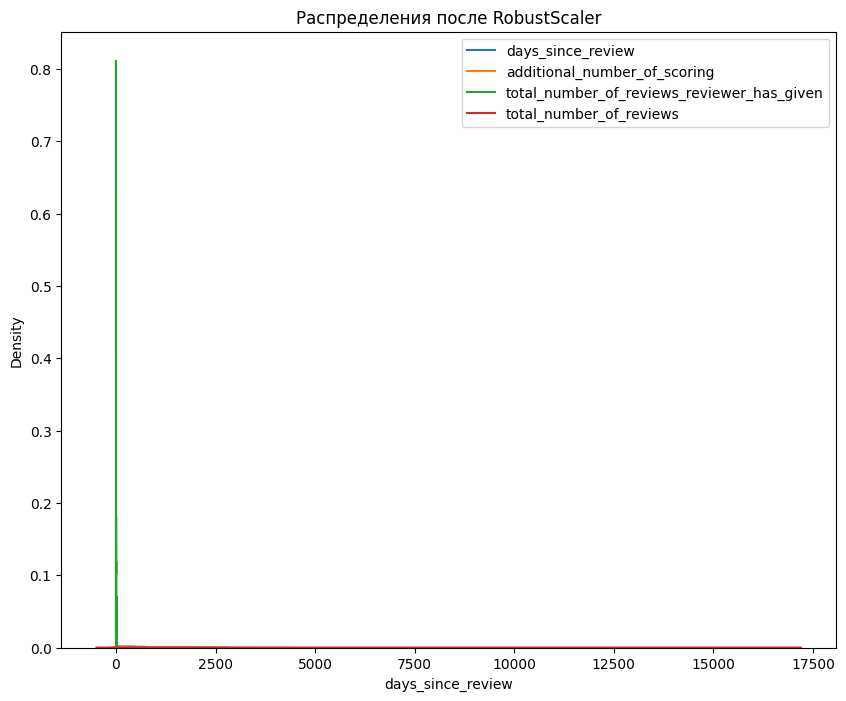

In [536]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(train_data['days_since_review'], ax=ax1, label='days_since_review')
sns.kdeplot(train_data['additional_number_of_scoring'], ax=ax1, label='additional_number_of_scoring')
sns.kdeplot(train_data[train_data['total_number_of_reviews_reviewer_has_given'] < 10]['total_number_of_reviews_reviewer_has_given'], ax=ax1, label='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(train_data['total_number_of_reviews'], ax=ax1, label='total_number_of_reviews')
plt.legend();

### Отбор признаков

Для начала просто удалим все не числовые, использованные признаки которые нам больше не нужны.

In [537]:
# функция удаления ненужных признаков
def drop_not_numeric_func(data):
    drop_colum_list = ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'country', 'city', 'room_class', 'room_type', 'review_year']
    data = data.drop(drop_colum_list, axis=1)
    return data

train_data = drop_not_numeric_func(train_data)

In [538]:
# разделим признаки на непрерывные и категориальные, не включая наш таргет reviewer_score
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'additional_number_of_scoring', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 
            'days_since_review', 'quality_of_life', 'avg_month_salary', 'positiv_emo_words', 'negativ_emo_words', 'people_count', 'nights_count', '0_review_word_counts_ratio', 'average_score', 'reviewer_score']

# категориальные признаки
cat_cols = ['lat', 'lng', 'review_month', 'review_quarter', 'country_equal_nation', 'leisure_trip', 'business_trip', 'with_view', 'with_pet', 'with_child', 'number_of_places', 
            'king_size', 'room_type_encode', 'country_United Kingdom', 'country_France', 'country_Netherlands', 'country_Italy', 'country_Austria', 'country_Spain', 'room_class_0', 'room_class_1',
            'room_class_2', 'room_class_3', 'room_class_4', 'review_year_encode', 'reviewer_score']

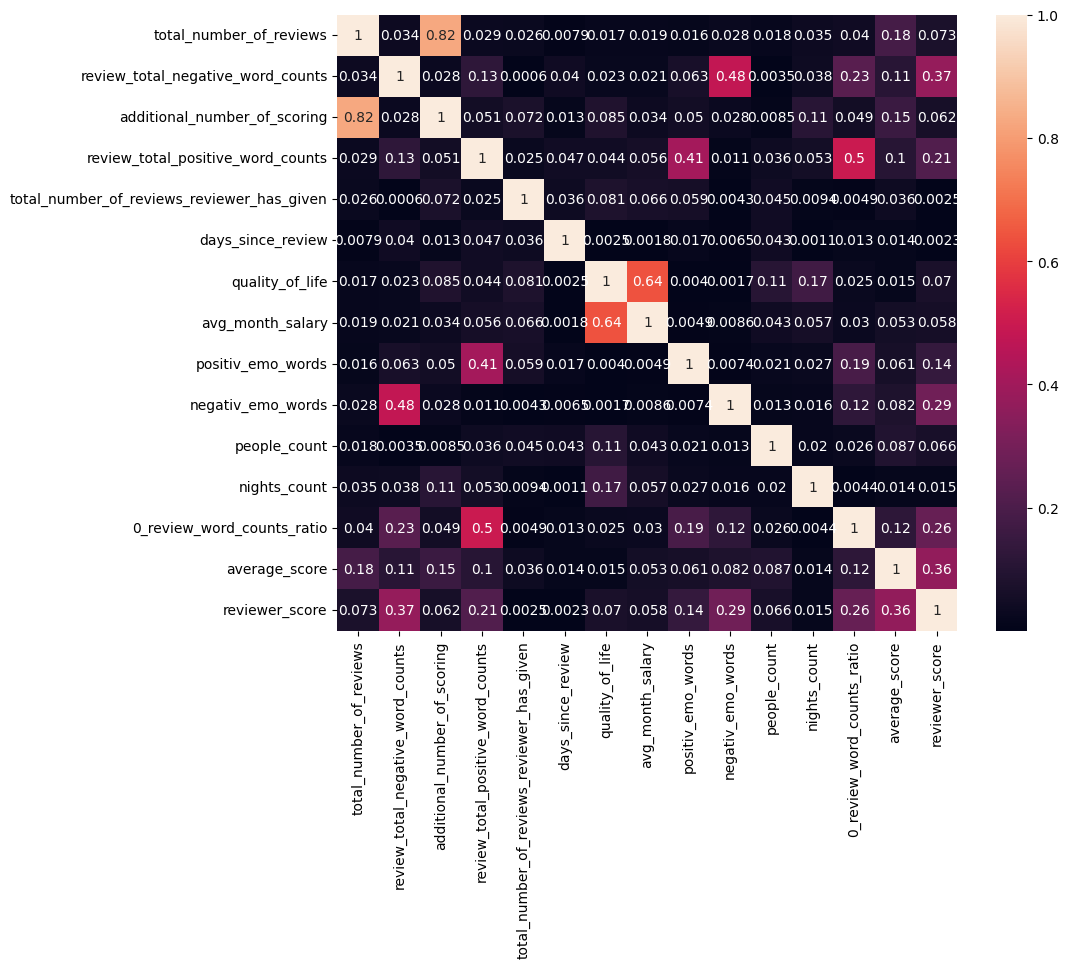

In [539]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(train_data[num_cols].corr().abs(), annot=True);

Удаляем additional_number_of_scoring

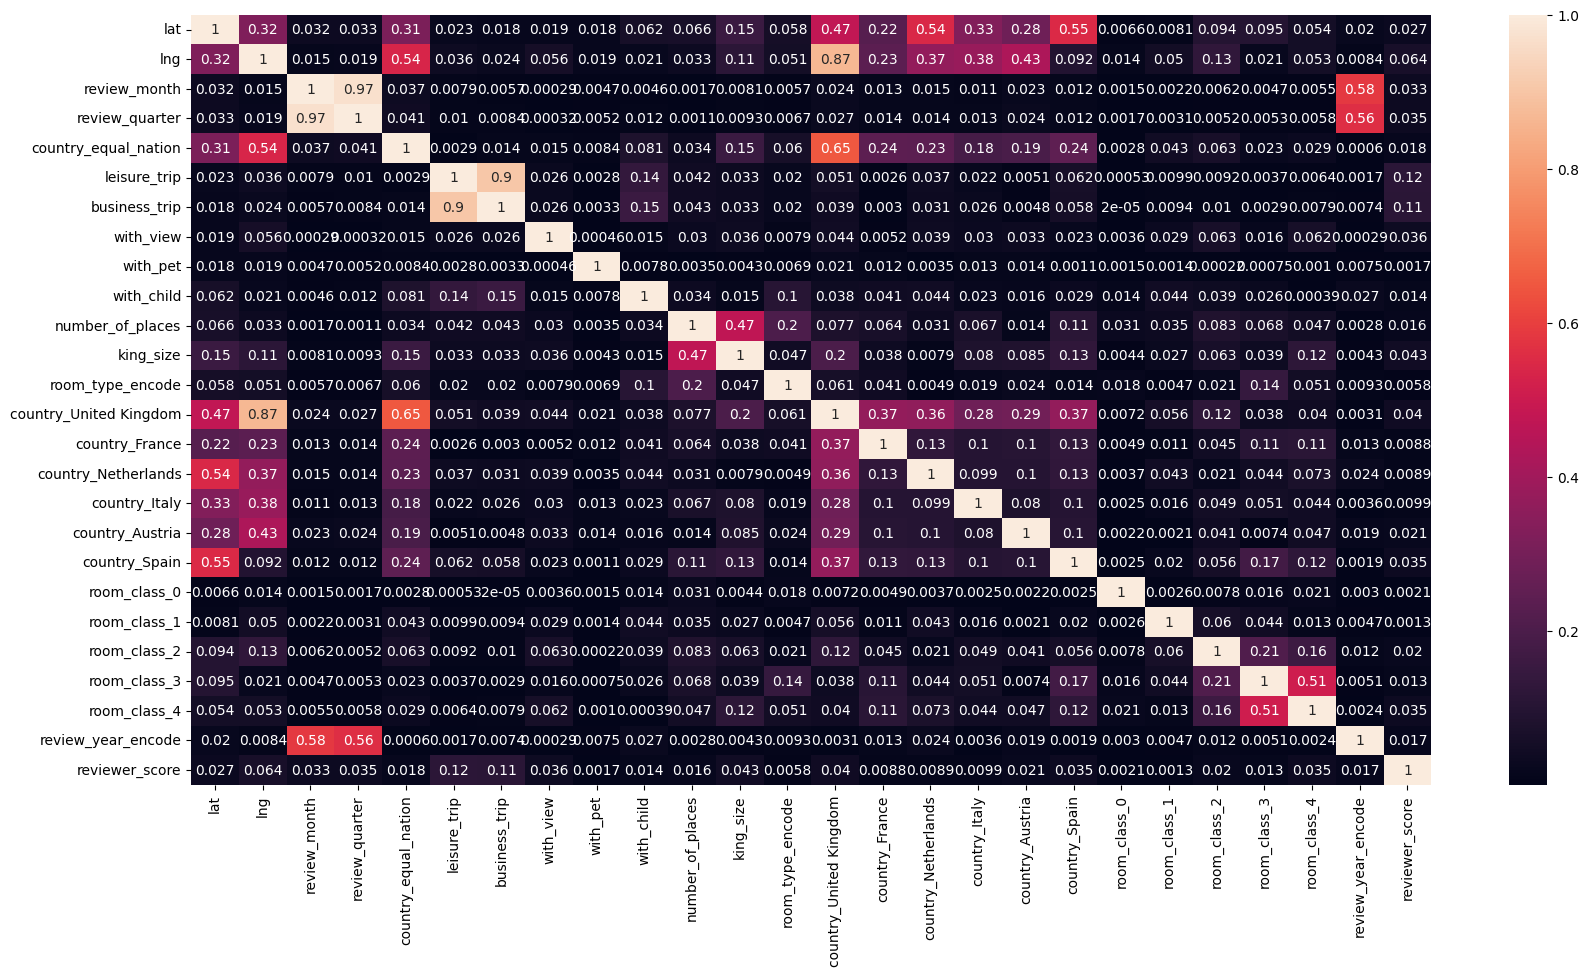

In [540]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(train_data[cat_cols].corr(method = 'spearman').abs(), annot=True);

Удаляем review_month, lng

In [541]:
# функция удаления мультиколлинеарных признаков
def drop_multicoll_func(data):
    drop_colum_list = ['additional_number_of_scoring', 'review_month', 'lng'] #
    data = data.drop(drop_colum_list, axis=1)
    return data

train_data = drop_multicoll_func(train_data)

***Разделим выборку на X и y***

In [542]:
y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

**И проведём оценку значимости наших признаков для таргета.**

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [543]:
num_cols.remove('additional_number_of_scoring')
num_cols.remove('reviewer_score')
cat_cols.remove('review_month')
cat_cols.remove('lng')
cat_cols.remove('reviewer_score')

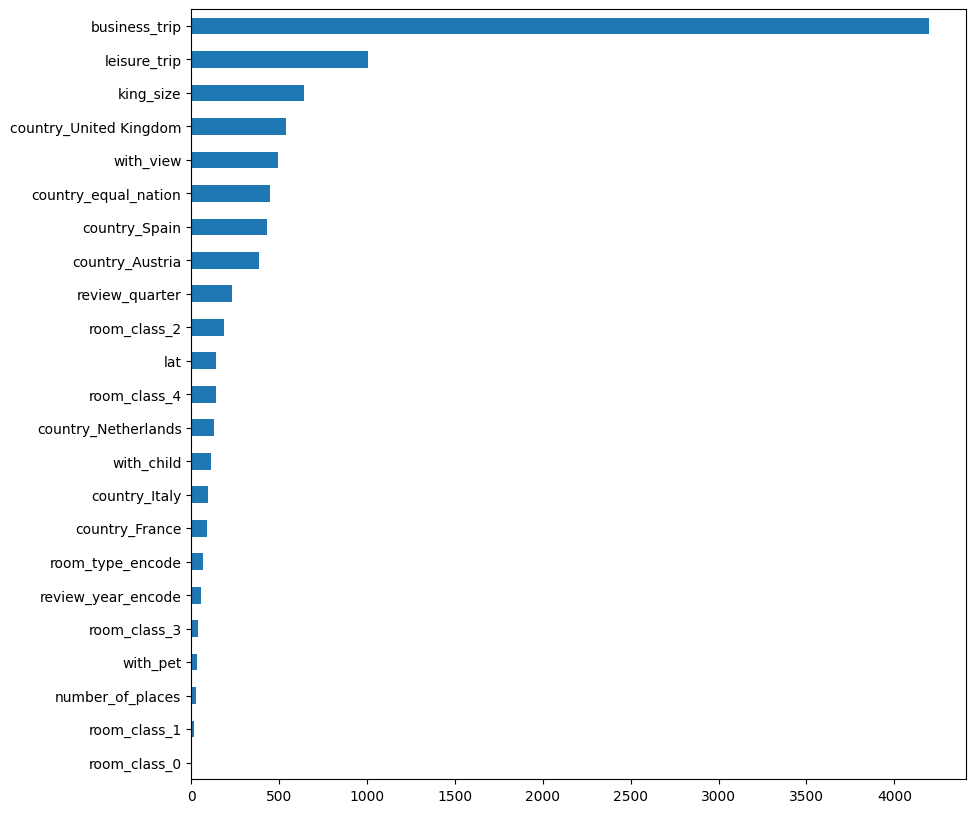

In [544]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

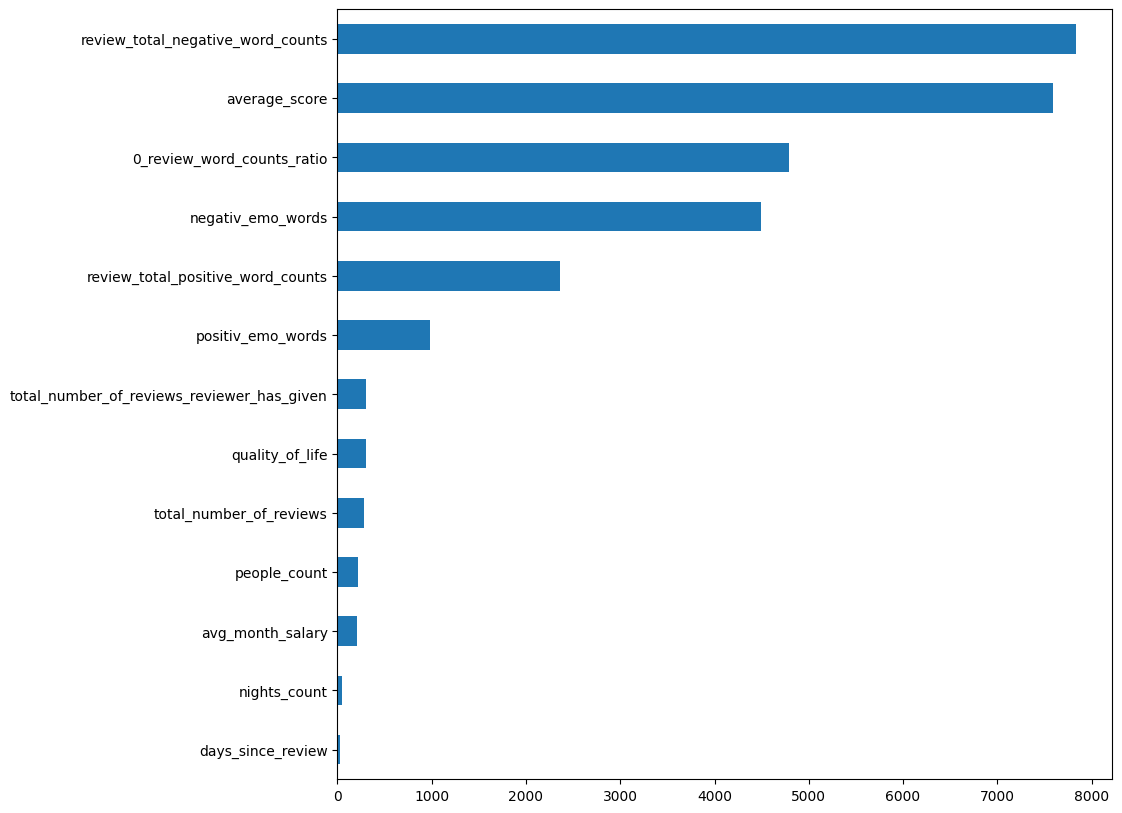

In [545]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

## Моделирование

In [546]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386496 non-null  float64
 1   review_total_negative_word_counts           386496 non-null  int64  
 2   total_number_of_reviews                     386496 non-null  int64  
 3   review_total_positive_word_counts           386496 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 5   reviewer_score                              386496 non-null  float64
 6   days_since_review                           386496 non-null  int64  
 7   lat                                         386496 non-null  float64
 8   0_review_word_counts_ratio                  386496 non-null  float64
 9   0_a_n_o_s__t_n_o_r                          386496 non-null  float64
 

In [547]:
train_data_2 = train_data.copy()

In [548]:
train_data_2['pos_pol_subj'] = abs(train_data_2['pos_polarity']) - abs(train_data_2['pos_subjectivity'])
train_data_2['neg_pol_subj'] = abs(train_data_2['neg_polarity']) - abs(train_data_2['neg_subjectivity'])


In [549]:
y = train_data_2.reviewer_score.values            # наш таргет
X = train_data_2.drop(['reviewer_score'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [550]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

#0.122687

MAPE: 0.12268790714889712


<Axes: >

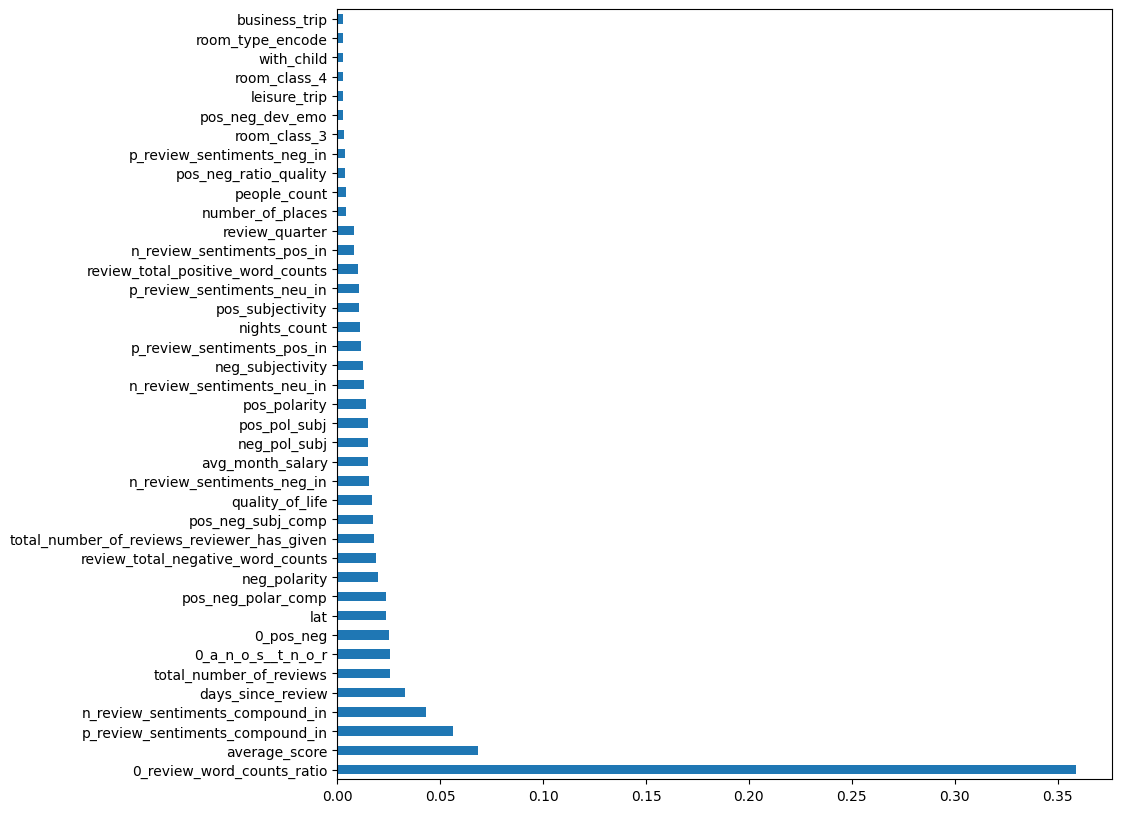

In [551]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')